# Discovering hidden factors of variation in deep networks

**This is an example of how to implement the autoencoder architecture from [Cheung et al. (2014)](http://arxiv.org/abs/1412.6583) in Lasagne.** This uses the code from the MNIST example bundled with Lasagne, so you will need to have the `mnist.py` file available for importing.

In [1]:
%matplotlib inline
import os
os.environ["THEANO_FLAGS"]= "device=gpu0"

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne as nn
w, h = 64, 64

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m


In [3]:
from skimage.transform import resize
from skimage.filter import threshold_otsu

def binarize(X):
    X_b = np.empty(X.shape, dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = 1. * (X[i] <= threshold_otsu(X[i]))
    return X_b

def resize_all(X, w, h):
    if X.shape[1] == w and X.shape[2] == h:
        return X
    X_b = np.empty((X.shape[0], w, h), dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = resize(X[i], (w, h))
    return X_b    


**We'll define the model listed in the first column of Table 1 in the paper.**

This model has an encoder with two ReLU layers. In the paper they both have 500 units but we'll make this configurable so we can speed up the experiment a bit if necessary.

On top of the encoder are two representation layers: one is a 10-way softmax layer which represents the class of the input. This is the observed representation layer. Then there is also a latent representation layer which has two additional linear units (the authors use only two units for easy visualization).

Both representation layers are concatenated and the decoder is stacked on top. This consists of three layers: two hidden ReLU layers with again 500 units, and finally a linear reconstruction layer with 784 outputs.

In [4]:
def build_model(input_dim, output_dim, batch_size,
                num_hidden_units=500):
    l_in = nn.layers.InputLayer((batch_size, input_dim))
    
    # encoder
    l_encoder1 = nn.layers.DenseLayer(l_in, num_units=num_hidden_units)
    l_encoder2 = nn.layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
    l_encoder3 = nn.layers.DenseLayer(l_encoder2, num_units=num_hidden_units)
    l_encoder4 = nn.layers.DenseLayer(l_encoder3, num_units=num_hidden_units)
    
    # learned representation
    l_observed = nn.layers.DenseLayer(l_encoder4, num_units=output_dim,
                                      nonlinearity=T.nnet.softmax)
    
    l_latent = nn.layers.DenseLayer(l_encoder4, num_units=20,
                                    nonlinearity=None) # linear
    
    l_representation = nn.layers.concat([l_observed, l_latent])
    
    # decoder
    l_decoder1 = nn.layers.DenseLayer(l_representation, num_units=num_hidden_units)
    l_decoder2 = nn.layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
    l_decoder3 = nn.layers.DenseLayer(l_decoder2, num_units=num_hidden_units)
    l_decoder4 = nn.layers.DenseLayer(l_decoder3, num_units=num_hidden_units)
    l_decoder_out = nn.layers.DenseLayer(l_decoder4, num_units=input_dim,
                                       nonlinearity=None)
    
    return l_in, l_decoder_out, l_observed, l_latent

In [5]:
def build_model_cnn(input_dim, output_dim, batch_size):
    ## CNN
    nb_filters=32
    size_filters=5
    nb_hidden=500
    nb_intermediate=2000
    nb_outputs=10
    corruption=False

    nb_filters_encoder = nb_filters
    nb_filters_decoder = nb_filters
    size_filters_encoder = size_filters
    size_filters_decoder = size_filters

    l_in = layers.InputLayer((None, w*h))


    x_in_reshaped = layers.ReshapeLayer(l_in, ([0], 1, w, h))

    # conv1
    l_conv = cuda_convnet.Conv2DCCLayer(
        x_in_reshaped,
        num_filters=nb_filters_encoder,
        filter_size=(size_filters, size_filters_encoder),
        nonlinearity=nonlinearities.rectify,
        dimshuffle=True,
    )
    l_intermediate = layers.DenseLayer(
        l_conv,
        num_units=nb_intermediate,
        nonlinearity=nonlinearities.rectify,
    )
    #code layer

    l_x_code = layers.DenseLayer(
        l_intermediate,
        num_units=nb_hidden,
        nonlinearity=nonlinearities.linear,
    )

    l_observed = layers.DenseLayer(l_intermediate, 
                                   num_units=output_dim,
                                    nonlinearity=T.nnet.softmax)

    l_latent = layers.DenseLayer(l_intermediate, 
                                 num_units=2,
                                 nonlinearity=None) # linear

    hid = layers.ConcatLayer([l_latent, l_observed], axis=1)


    # unflatten layer
    hid = layers.DenseLayer(hid,
                            num_units=nb_filters_decoder * (w - size_filters_decoder + 1) * (h - size_filters_decoder + 1))
    hid = layers.ReshapeLayer(hid,
                              ([0], nb_filters_decoder, (w - size_filters_decoder + 1), (h - size_filters_decoder + 1)))

    l_unconv = Conv2DLayer(
        hid,
        num_filters=32,
        filter_size=(size_filters_decoder, size_filters_decoder),
        nonlinearity=nonlinearities.rectify,
        border_mode="full"
    )
    l_unconv_sum = SumLayer(l_unconv, axis=1)
    l_decoder_out = layers.ReshapeLayer(l_unconv_sum, ([0], w*h))
    
    return l_in, l_decoder_out, l_observed, l_latent

Next, **we'll define the cost function**. This consists of three parts: `alpha * U + beta * S + gamma * C` (formula 3 in the paper). `U` is the reconstruction cost, `S` is the supervised cost and `C` is the so-called "XCov" cost which disentangles the observed and latent variables of the encoder.

In [6]:
def cost(x, y, x_recon, y_pred, z, alpha=1.0, beta=10.0, gamma=10.0):
    """
    x, y: the input and the corresponding label
    x_recon: the model reconstruction of the input
    y_pred: the model prediction (observed variables)
    z: the latent variables
    """
    # reconstruction cost: mean squared error
    U = ((x - x_recon)**2).sum(axis=1).mean()
    
    # supervised cost: categorical cross-entropy
    S = T.mean(T.nnet.categorical_crossentropy(y_pred, y))
    
    # XCov cost: cross-covariance
    y_pred_mean = T.mean(y_pred, axis=0, keepdims=True)
    z_mean = T.mean(z, axis=0, keepdims=True)
    y_pred_centered = y_pred - y_pred_mean # (n, i)
    z_centered = z - z_mean # (n, j)
    
    outer_prod = (y_pred_centered.dimshuffle(0, 1, 'x') *
                  z_centered.dimshuffle(0, 'x', 1)) # (n, i, j)
    C = 0.5 * T.sum(T.sqr(T.mean(outer_prod, axis=0)))
    
    # the total cost is a weighted sum
    return alpha * U + beta * S + gamma * C

In [7]:
from lasagne.datasets.mnist import MNIST
from sklearn.cross_validation import train_test_split
import lasagne.easy
import numpy as np
def load_data():
    """Get data with labels, split into training, validation and test set."""
    from lasagne.datasets.fonts import Fonts
    
    data = Fonts(kind="all_64",
                 labels_kind="letters")
    data.load()
    
    #data = MNIST()
    #data.load()
    
    X = data.X
    #X = X.reshape((X.shape[0], 28, 28))
    #X = resize_all(X, w, h)
    
    #X = binarize(X)
    #X = 1 - X
    X = X.astype(np.float32)
    X = X.reshape((X.shape[0], w*h))
    y = data.y
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25)
    
    return dict(
        X_train=theano.shared(lasagne.utils.floatX(X_train)),
        y_train=T.cast(theano.shared(y_train), 'int32'),
        X_valid=theano.shared(lasagne.utils.floatX(X_valid)),
        y_valid=T.cast(theano.shared(y_valid), 'int32'),
        X_test=theano.shared(lasagne.utils.floatX(X_test)),
        y_test=T.cast(theano.shared(y_test), 'int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_dim=X_train.shape[1],
        output_dim=len(set(y)),
    )


Now let's tie everything together in the main training loop.

In [8]:
from mnist import train
import time

num_epochs = 120
batch_size = 100

print("Loading data...")
dataset = load_data()
print(dataset.keys())


Loading data...
['X_test', 'num_examples_train', 'X_train', 'num_examples_valid', 'num_examples_test', 'output_dim', 'X_valid', 'y_valid', 'y_train', 'input_dim', 'y_test']


In [9]:

print("Building model and compiling functions...")
l_in, l_decoder_out, l_observed, l_latent = build_model(
    input_dim=dataset['input_dim'],
    output_dim=dataset['output_dim'],
    batch_size=batch_size,
    num_hidden_units=2000
)

x = l_in.input_var
y = T.ivector('y')
x_recon, y_pred, z = nn.layers.get_output([l_decoder_out, l_observed, l_latent])
# Note that we call get_output() once to get all the model outputs.
# This is to guarantee they are consistent and share computations where
# possible. When the network contains nondeterminism (such as dropout
# regularization), guaranteeing this consistency is crucially important.
loss = cost(x, y, x_recon, y_pred, z, 
            alpha=1, 
            beta=0, 
            gamma=0.)
params = nn.layers.get_all_params(l_decoder_out)

# # add some L2 regularization
# params_reg = nn.layers.get_all_params(l_decoder_out, regularizable=True)
# reg = sum(T.sum(p**2) for p in params_reg)
# loss += 0.01 * reg

# The authors mention that they use adadelta, let's do the same
updates = nn.updates.adadelta(loss, params, learning_rate=0.1)

# compile iteration functions
batch_index = T.iscalar('batch_index')
batch_slice = slice(batch_index * batch_size,
                    (batch_index + 1) * batch_size)

pred = T.argmax(y_pred, axis=1)
accuracy = T.mean(T.eq(pred, y), dtype=theano.config.floatX)

iter_train = theano.function(
    [batch_index], loss,
    updates=updates,
    givens={
        x: dataset['X_train'][batch_slice],
        y: dataset['y_train'][batch_slice],
    },
)

iter_valid = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_valid'][batch_slice],
        y: dataset['y_valid'][batch_slice],
    },
)

iter_test = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_test'][batch_slice],
        y: dataset['y_test'][batch_slice],
    },
)

iter_funcs =  dict(
    train=iter_train,
    valid=iter_valid,
    test=iter_test,
)

X = T.matrix('X')
get_reconstruction_error_train = theano.function(
    [],
    ((l_decoder_out.get_output(x) - x)**2).sum(axis=1).mean(),
    givens={
        x: dataset['X_train'],
        #y: dataset['y_train'],
    },
)
get_reconstruction_error_test = theano.function(
    [],
    ((l_decoder_out.get_output(x) - x)**2).sum(axis=1).mean(),
    givens={
        x: dataset['X_train'],
        #y: dataset['y_train'],
    },

)

U = ((x - x_recon)**2).sum(axis=1).mean()


print("Starting training...")
now = time.time()
try:
    for epoch in train(iter_funcs, dataset, batch_size=batch_size):
        print("Epoch {} of {} took {:.3f}s".format(
            epoch['number'], num_epochs, time.time() - now))
        now = time.time()
        print("  training loss:\t\t{:.6f}".format(epoch['train_loss']))
        print("  validation loss:\t\t{:.6f}".format(epoch['valid_loss']))
        print("  validation accuracy:\t\t{:.2f} %".format(
            epoch['valid_accuracy'] * 100))
        rec_train = get_reconstruction_error_train()
        rec_valid = get_reconstruction_error_test()

        print("train rec :{0}".format(rec_train))
        print("valid rec :{0}".format(rec_valid))

        if epoch['number'] >= num_epochs:
            break

except KeyboardInterrupt:
    pass

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/init.py:91: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/grid_mnt/vol__vol_U__u/gridcl/mehdicherti/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:73: UserWarning: layer.get_output(...) is deprecate

Building model and compiling functions...
Starting training...
Epoch 1 of 120 took 11.196s
  training loss:		1567.430054
  validation loss:		380.594604
  validation accuracy:		3.92 %
train rec :381.347442627
valid rec :381.347442627
Epoch 2 of 120 took 12.897s
  training loss:		457.607452
  validation loss:		392.634674
  validation accuracy:		3.92 %
train rec :393.275421143
valid rec :393.275421143
Epoch 3 of 120 took 12.892s
  training loss:		379.425018
  validation loss:		365.281616
  validation accuracy:		3.92 %
train rec :365.988189697
valid rec :365.988189697
Epoch 4 of 120 took 12.893s
  training loss:		364.742859
  validation loss:		323.086060
  validation accuracy:		3.92 %
train rec :323.868011475
valid rec :323.868011475
Epoch 5 of 120 took 12.894s
  training loss:		338.163849
  validation loss:		357.129333
  validation accuracy:		3.92 %
train rec :357.622039795
valid rec :357.622039795
Epoch 6 of 120 took 12.892s
  training loss:		307.950043
  validation loss:		259.343109
  v

Now let's create a function that computes the latent representation variables z so we can visualize them on the test set.

In [10]:
z = nn.layers.get_output(l_latent)

compute_z = theano.function(
    [], z,
    givens={
        x: dataset['X_test'],
    },
)

z_vals = compute_z()

In [11]:
from scipy.stats import multivariate_normal
m = z_vals.mean(axis=0)
s = np.cov(z_vals.T)

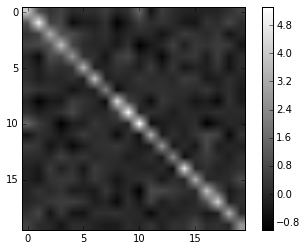

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(s, cmap="gray")
plt.colorbar()
plt.show()

In [13]:
y = nn.layers.get_output(l_observed)

compute_y = theano.function(
    [], y,
    givens={
        x: dataset['X_test'],
    },
)

y_vals = compute_y()

MemoryError: Error allocating 67032000 bytes of device memory (out of memory).
Apply node that caused the error: GpuDot22(GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)].0, W)
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(8379, 2000), (2000, 2000)]
Inputs strides: [(2000, 1), (2000, 1)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [14]:
z_sampler = multivariate_normal(m, s)

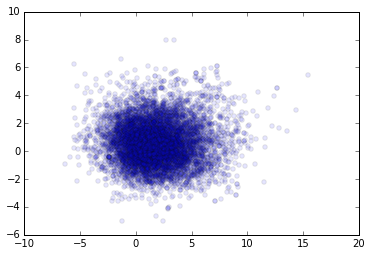

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(z_vals[:, 0], z_vals[:, 1], alpha=0.1)
plt.show()

This corresponds to figure 4a in the paper. Our latent variables have a smaller magnitude overall, but exhibit a roughly Gaussian distribution just like in the paper.

Now let's generate some reconstructions. Our aim is to reproduce figures 4b and 4c. We'll need to compile a function that allows us to set the desired values for the latent variables `y` and `z`.

Lasagne makes it possible to map any layer in the network to a custom expression by supplying a dictionary to `nn.layers.get_output()`. We'll make use of this to 'clamp' the observed and latent representation variables.

In [17]:
y_clamped = T.ivector('y_clamped')
z_clamped = T.matrix('z_clamped')

x_recon = nn.layers.get_output(l_decoder_out, {
        l_observed: nn.utils.one_hot(y_clamped, m=dataset["output_dim"]),
        l_latent: z_clamped,
    })

reconstruct = theano.function([y_clamped, z_clamped], x_recon)

x_clamped = T.matrix('X')
x_clamped_recon = nn.layers.get_output(l_decoder_out, x_clamped)
reconstruct_from_input = theano.function([x_clamped], x_clamped_recon)

In [18]:
R = z_vals.shape[1]#dim of hidden/code
nb = 10
ys = np.repeat(np.arange(dataset["output_dim"]), nb).astype('int32')
zs = np.tile(np.linspace(-0.5, 0.5, nb), dataset["output_dim"]).astype(theano.config.floatX)

z1s = np.zeros((ys.shape[0], R), dtype=theano.config.floatX)
z1s[:, 0] = zs

z2s = np.zeros((ys.shape[0], R), dtype=theano.config.floatX)
z2s[:, 1] = zs

print(z1s.shape, ys.shape)

((260, 20), (260,))


In [19]:
reconstructions_z1 = reconstruct(ys, z1s)
reconstructions_z2 = reconstruct(ys, z2s)

(260, 4096)


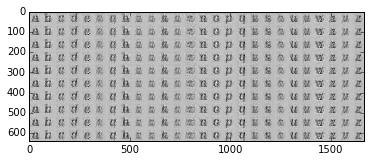

In [20]:
print(reconstructions_z1.shape)
im1 = reconstructions_z1.reshape(dataset["output_dim"], nb, w, h)

im1 = im1.transpose(1, 2, 0, 3)
im1 = im1.reshape(nb * w, dataset["output_dim"] * h)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

(260, 4096)


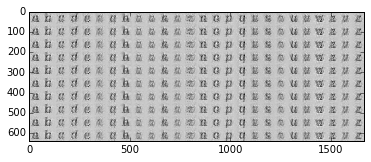

In [21]:
print(reconstructions_z1.shape)
im2 = reconstructions_z2.reshape(dataset["output_dim"], nb, w, h)

im2 = im2.transpose(1, 2, 0, 3)
im2 = im2.reshape(nb * w, dataset["output_dim"] * h)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()

The reconstructions show some interesting structure as `z1` and `z2` are varied. Pretty cool!

(260, 4096)


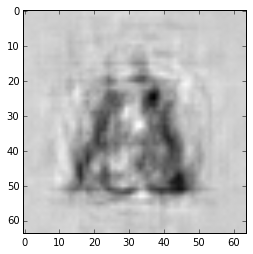

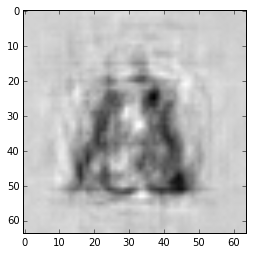

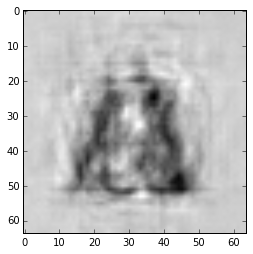

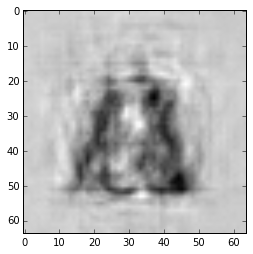

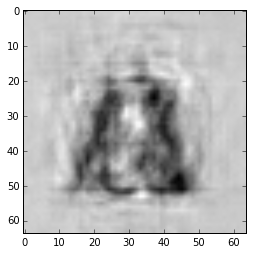

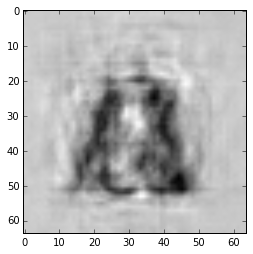

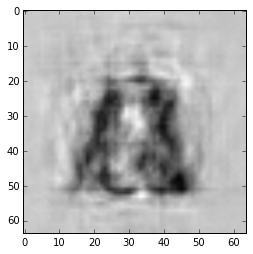

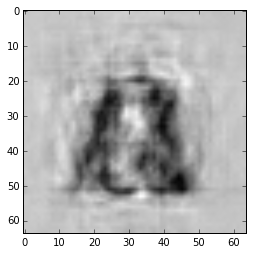

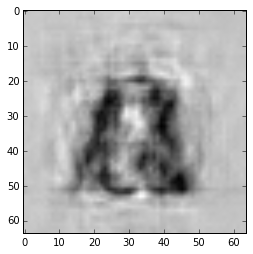

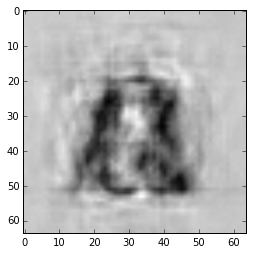

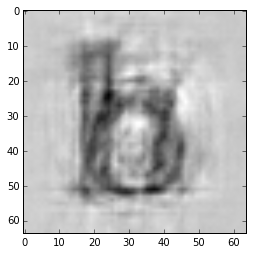

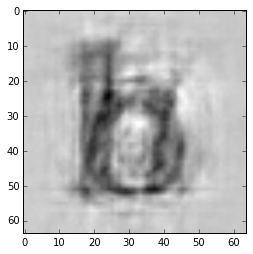

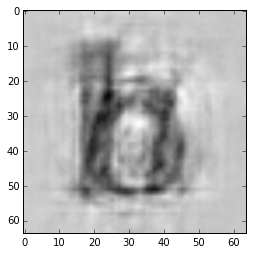

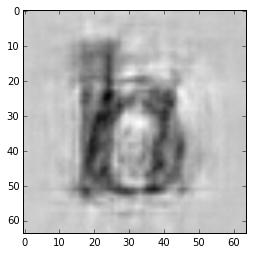

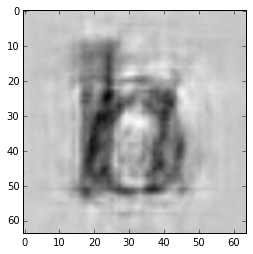

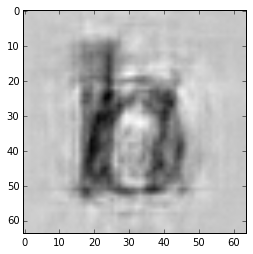

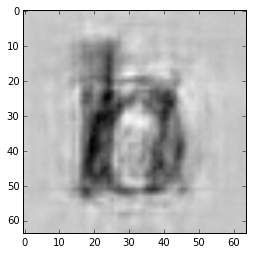

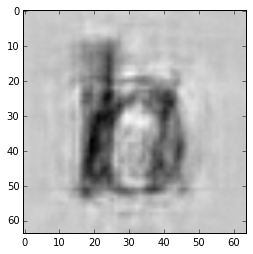

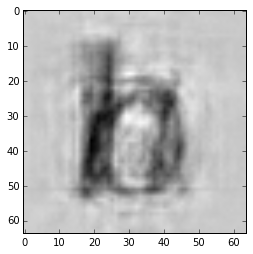

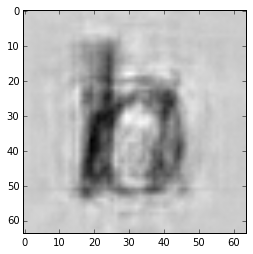

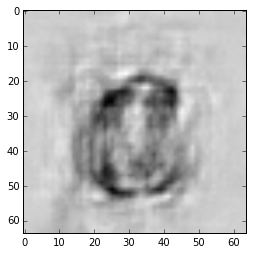

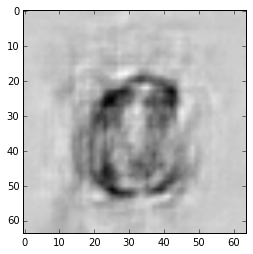

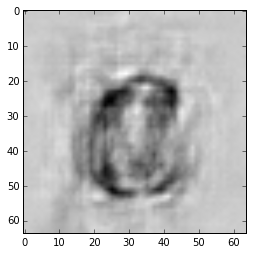

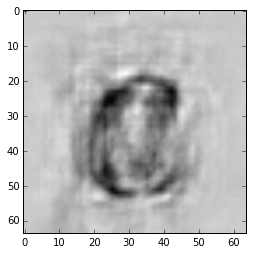

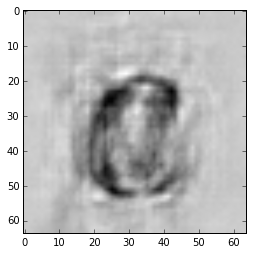

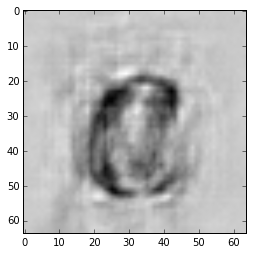

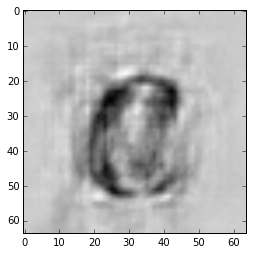

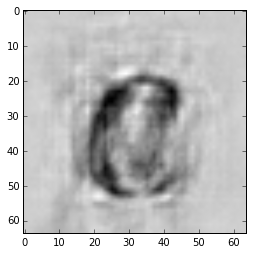

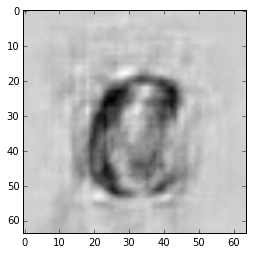

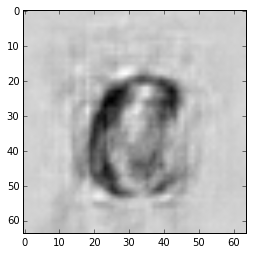

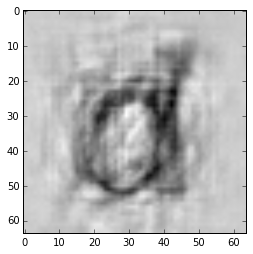

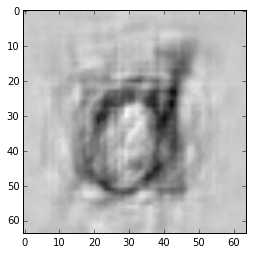

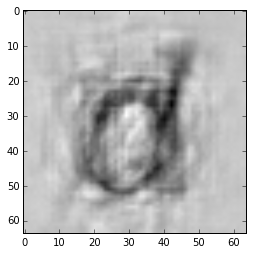

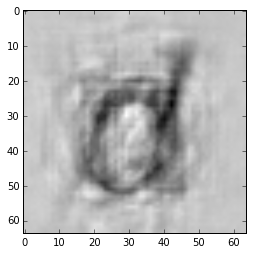

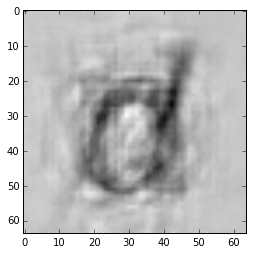

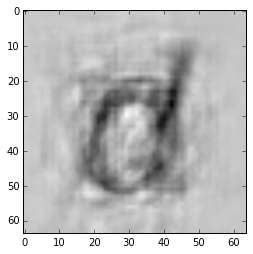

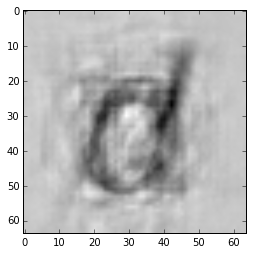

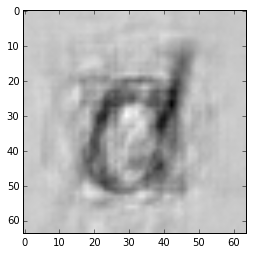

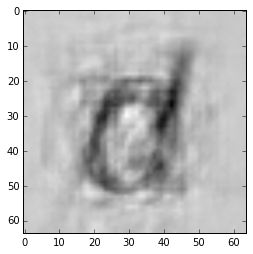

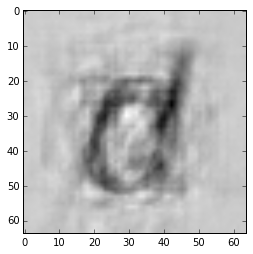

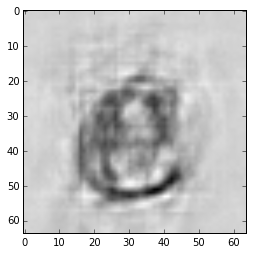

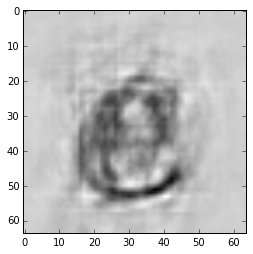

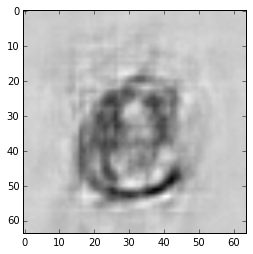

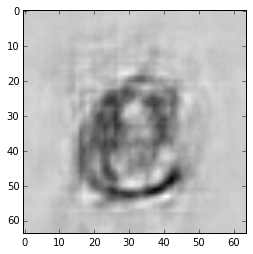

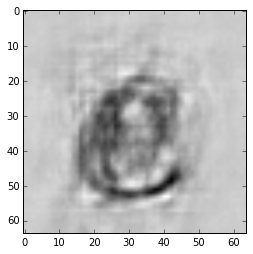

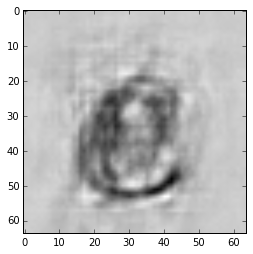

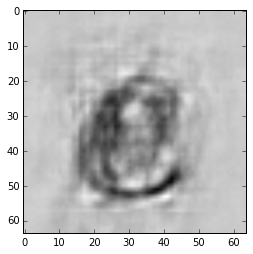

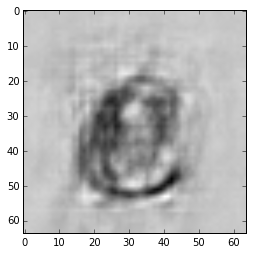

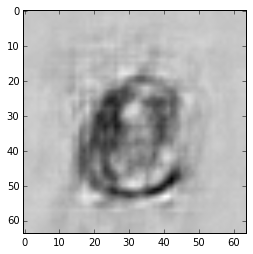

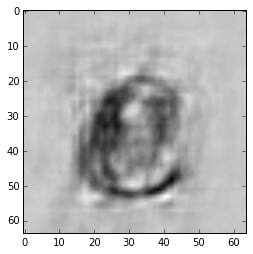

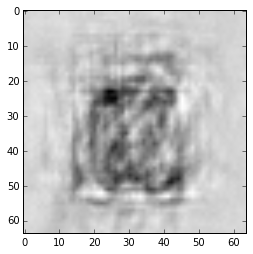

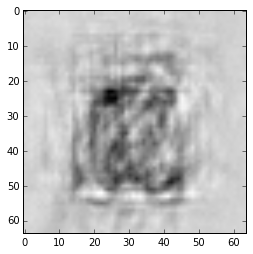

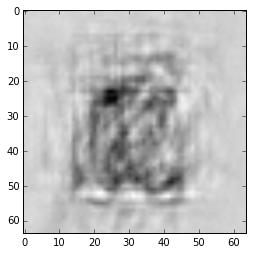

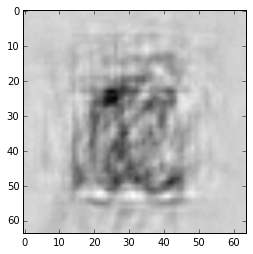

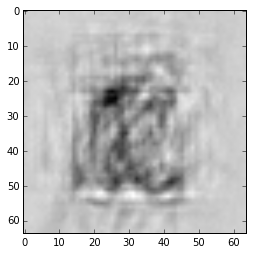

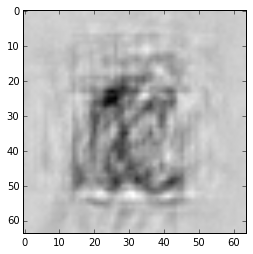

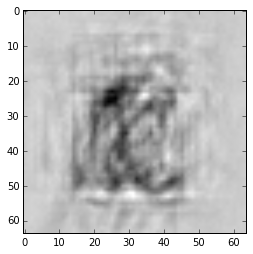

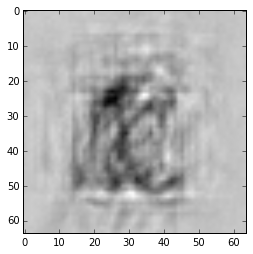

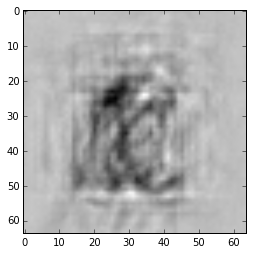

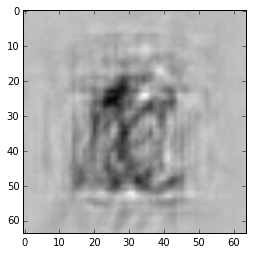

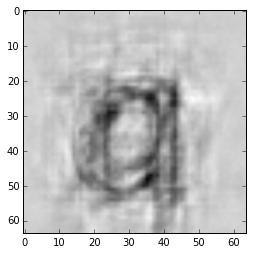

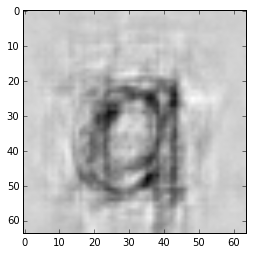

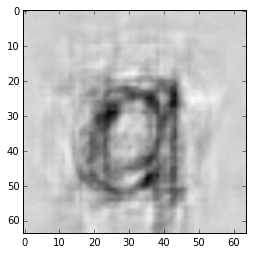

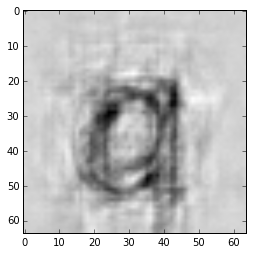

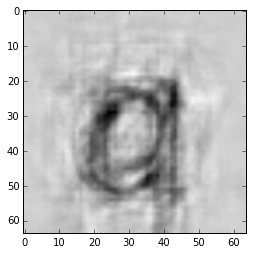

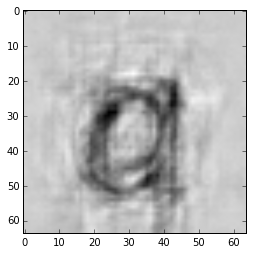

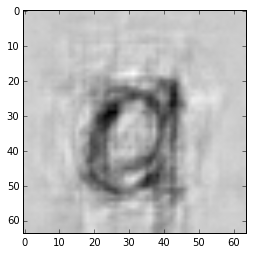

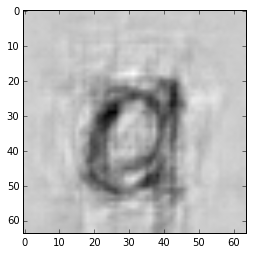

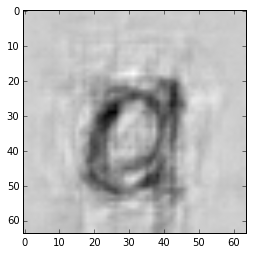

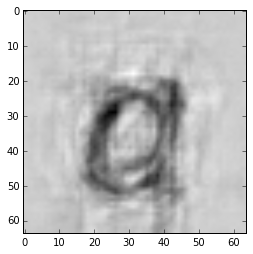

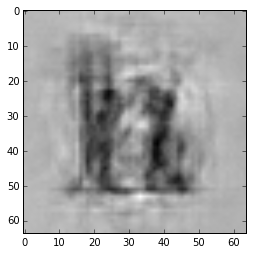

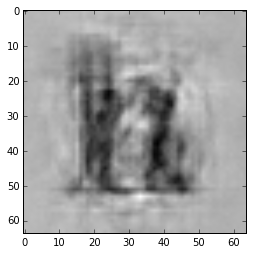

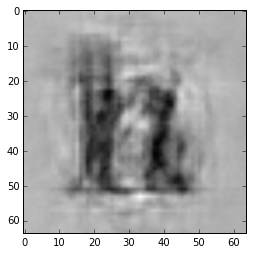

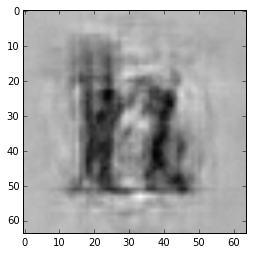

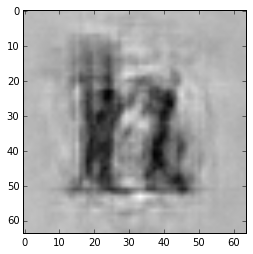

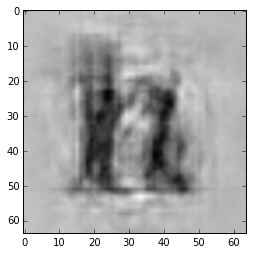

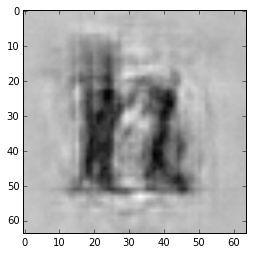

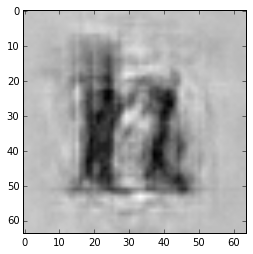

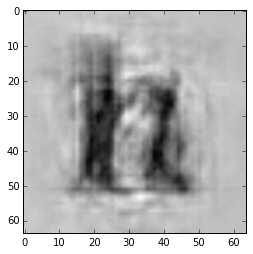

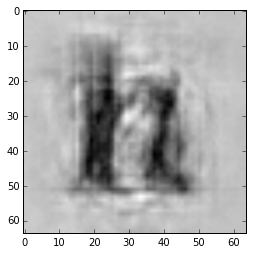

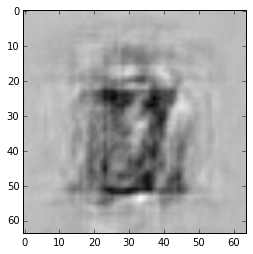

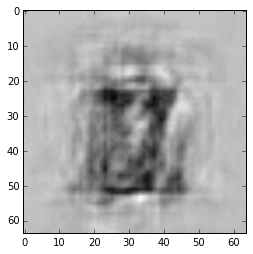

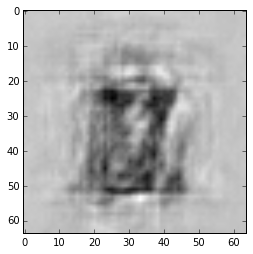

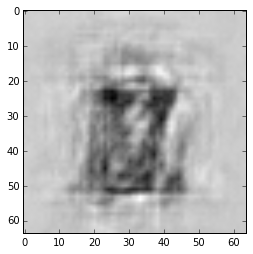

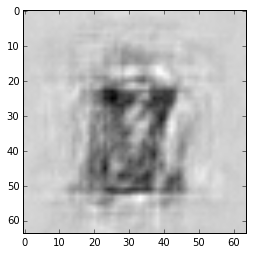

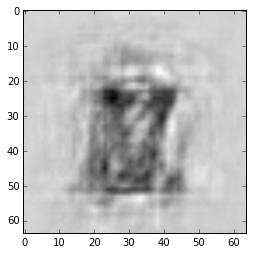

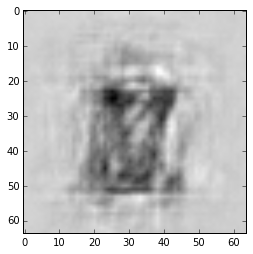

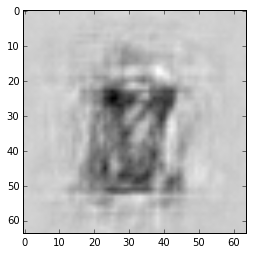

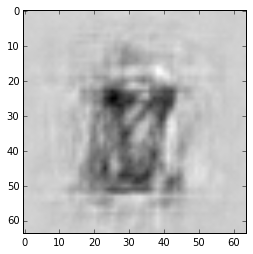

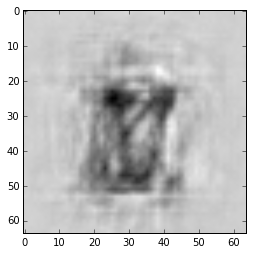

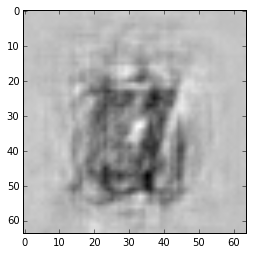

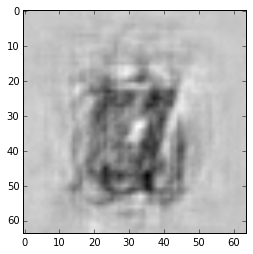

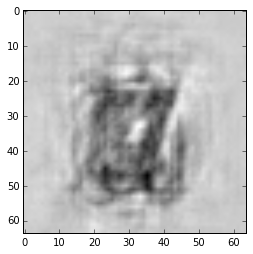

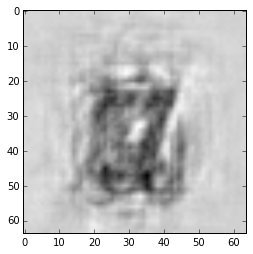

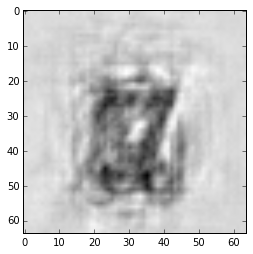

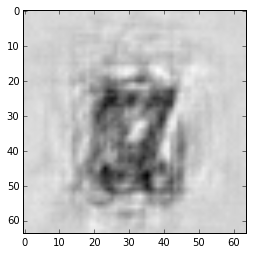

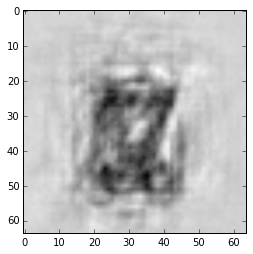

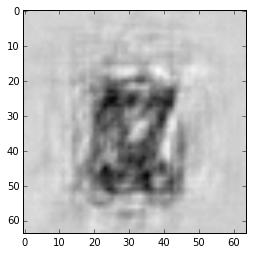

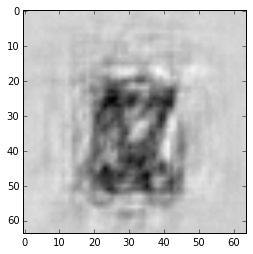

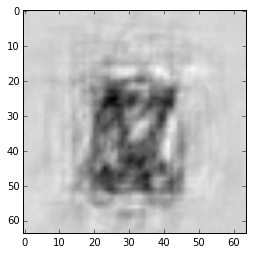

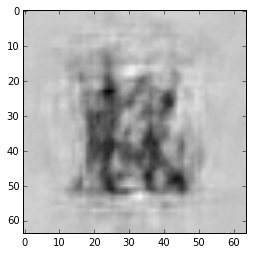

KeyboardInterrupt: 

In [22]:
print(reconstructions_z1.shape)
for i in range(reconstructions_z1.shape[0]):
    plt.clf()
    plt.imshow(reconstructions_z1[i].reshape((64, 64)), cmap="gray")
    plt.show()

## Sampler from empirical distribution of  z and reconstruct

In [23]:
nb = 10
#ys = dataset['output_dim']
ys = np.repeat(np.arange(dataset["output_dim"]), nb).astype('int32')
samples = z_sampler.rvs(size=nb*dataset["output_dim"])
reconstructions = reconstruct(ys, z1s)

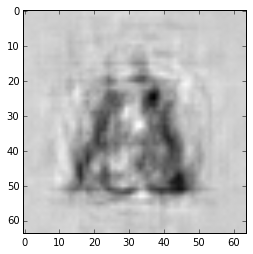

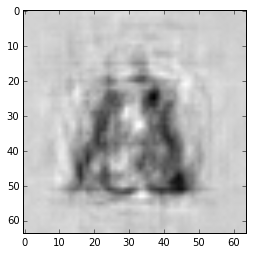

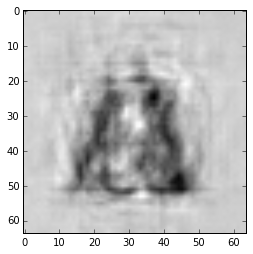

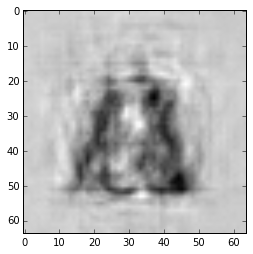

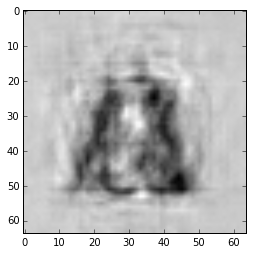

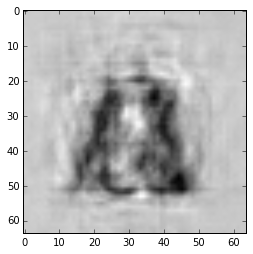

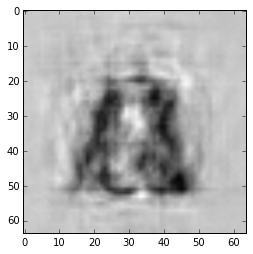

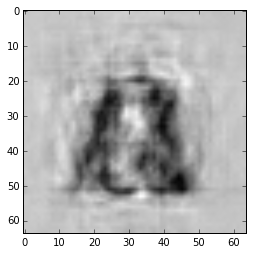

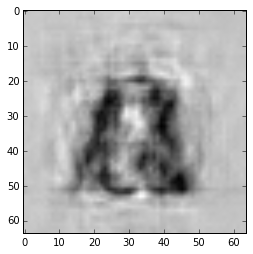

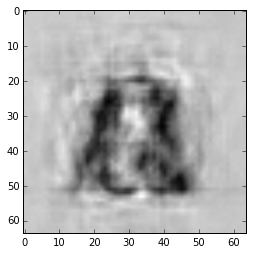

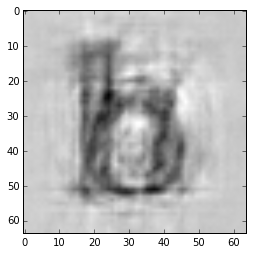

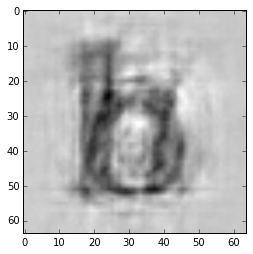

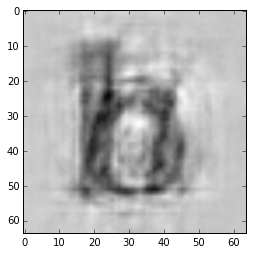

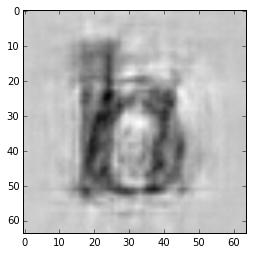

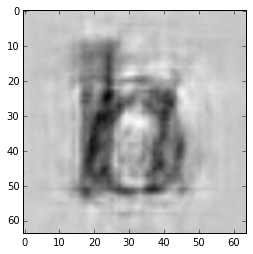

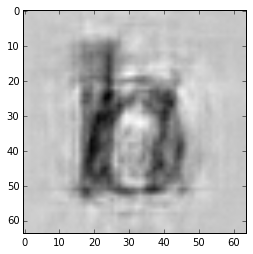

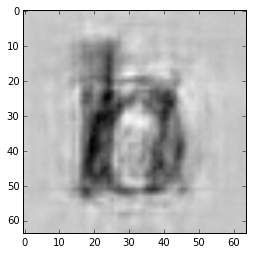

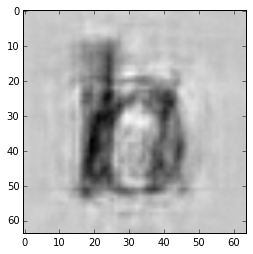

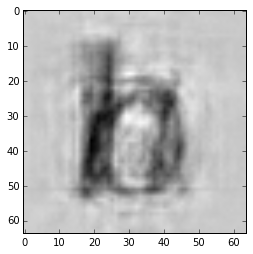

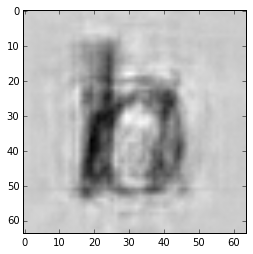

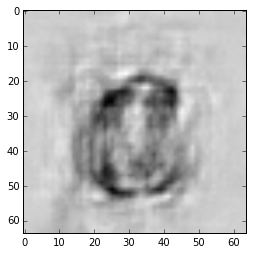

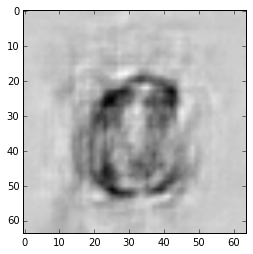

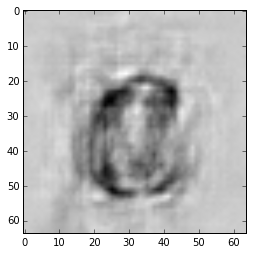

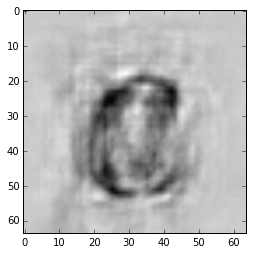

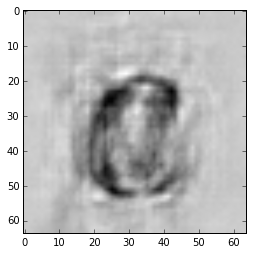

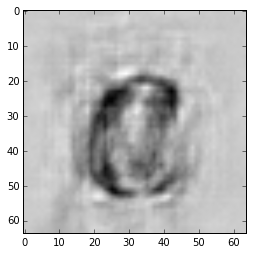

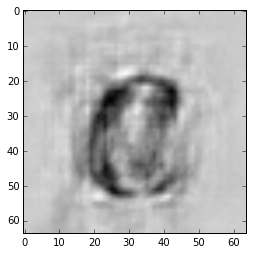

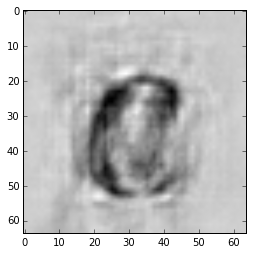

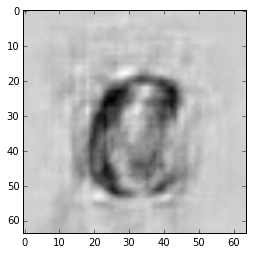

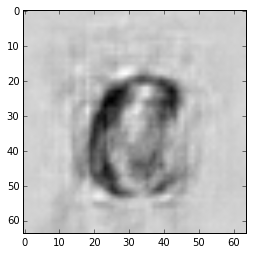

KeyboardInterrupt: 

In [24]:
for i in range(reconstructions.shape[0]):
    plt.clf()
    plt.imshow(reconstructions[i].reshape((w, h)), cmap="gray")
    plt.show()

## start from an input then reconstruct it

In [25]:
x = dataset["X_train"].get_value()[0:10]
x_hat = reconstruct_from_input(x)

In [26]:
print(m)

[ 1.82434046  0.57552248  1.19932127  0.22541656 -1.71922886  2.50995231
  0.40925878 -0.97182953  0.9455511  -0.63236105 -0.01987127  0.01345008
 -0.67077738  0.41479558 -0.42644861  0.59053808  0.25029573 -0.31783682
 -0.61415106 -1.85350895]


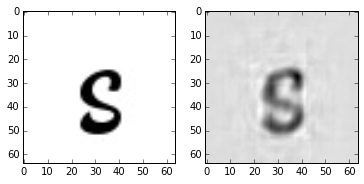

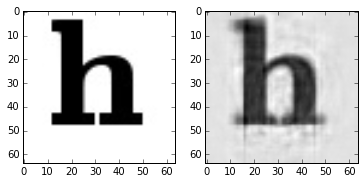

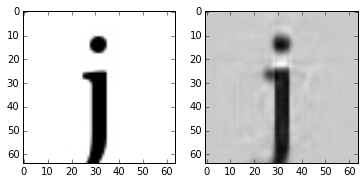

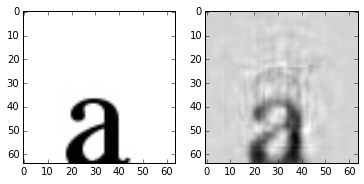

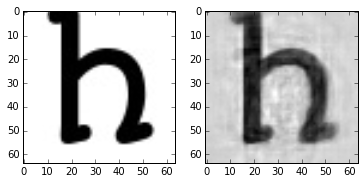

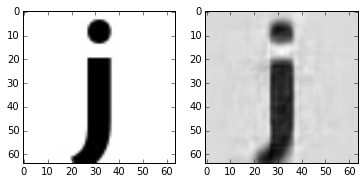

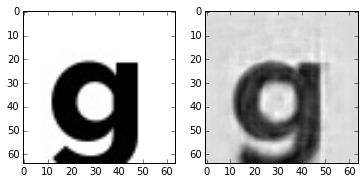

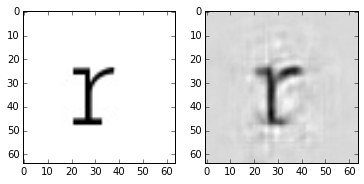

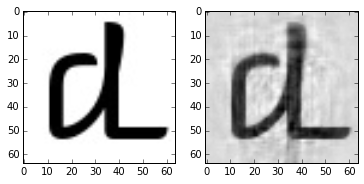

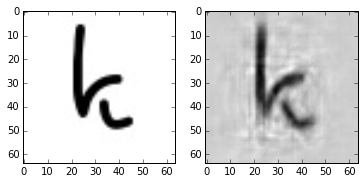

In [27]:
for i in range(x.shape[0]):
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.imshow(x[i].reshape((w, h)), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(x_hat[i].reshape((w, h)), cmap="gray")
    plt.show()